In [1]:
import mlflow
import mlflow.prophet
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from dotenv import load_dotenv
import datetime
# Load environment variables from .env file
load_dotenv()


experiment_name = "/Users/j.huertas@closerstillmedia.com/prophet"
try:
    mlflow.create_experiment(experiment_name)
except:
    print("experiment exists")
mlflow.set_experiment(experiment_name)

experiment exists


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3039328626124250', creation_time=1755624146266, experiment_id='3039328626124250', last_update_time=1755631968027, lifecycle_stage='active', name='/Users/j.huertas@closerstillmedia.com/prophet', tags={'mlflow.databricks.filesystem.experiment_permissions_check': 'test',
 'mlflow.experiment.sourceName': '/Users/j.huertas@closerstillmedia.com/prophet',
 'mlflow.experimentKind': 'custom_model_development',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'b.relf@closerstillmedia.com',
 'mlflow.ownerId': '7931383772120950'}>

# Model Loading and Prediction

In [17]:
def load_and_predict_prophet_model(model_uri, future_periods=30):
    """Load Prophet model and generate predictions."""

    # Load model
    loaded_model = mlflow.prophet.load_model(model_uri)

    # Generate future dataframe
    future = loaded_model.make_future_dataframe(periods=future_periods)

    # Add any required regressors or caps
    if hasattr(loaded_model, "extra_regressors") and loaded_model.extra_regressors:
        # You would need to provide values for external regressors
        # This is a simplified example
        for regressor in loaded_model.extra_regressors:
            future[regressor] = np.random.normal(1000, 100, len(future))

    if loaded_model.growth == "logistic":
        future["cap"] = 10000  # Set appropriate capacity

    # Generate predictions
    forecast = loaded_model.predict(future)

    return forecast, loaded_model


# Usage
run_id = "1655d93c38a4421cb6aa50a49c28e127"
model_uri = f"runs:/{run_id}/best_model"
predictions, loaded_model = load_and_predict_prophet_model(model_uri, future_periods=365)

In [18]:
predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,1030.193736,940.538800,1064.355006,1030.193736,1030.193736,-30.866676,-30.866676,-30.866676,-31.073506,-31.073506,-31.073506,0.206831,0.206831,0.206831,0.0,0.0,0.0,999.327060
1,2021-01-02,1030.303150,1038.919451,1163.257426,1030.303150,1030.303150,72.356656,72.356656,72.356656,69.854574,69.854574,69.854574,2.502081,2.502081,2.502081,0.0,0.0,0.0,1102.659806
2,2021-01-03,1030.412564,1046.325486,1165.604874,1030.412564,1030.412564,77.264672,77.264672,77.264672,72.498603,72.498603,72.498603,4.766068,4.766068,4.766068,0.0,0.0,0.0,1107.677236
3,2021-01-04,1030.521978,950.833862,1073.003959,1030.521978,1030.521978,-20.410260,-20.410260,-20.410260,-27.416787,-27.416787,-27.416787,7.006526,7.006526,7.006526,0.0,0.0,0.0,1010.111718
4,2021-01-05,1030.631392,949.740709,1078.795901,1030.631392,1030.631392,-17.563931,-17.563931,-17.563931,-26.795477,-26.795477,-26.795477,9.231546,9.231546,9.231546,0.0,0.0,0.0,1013.067462


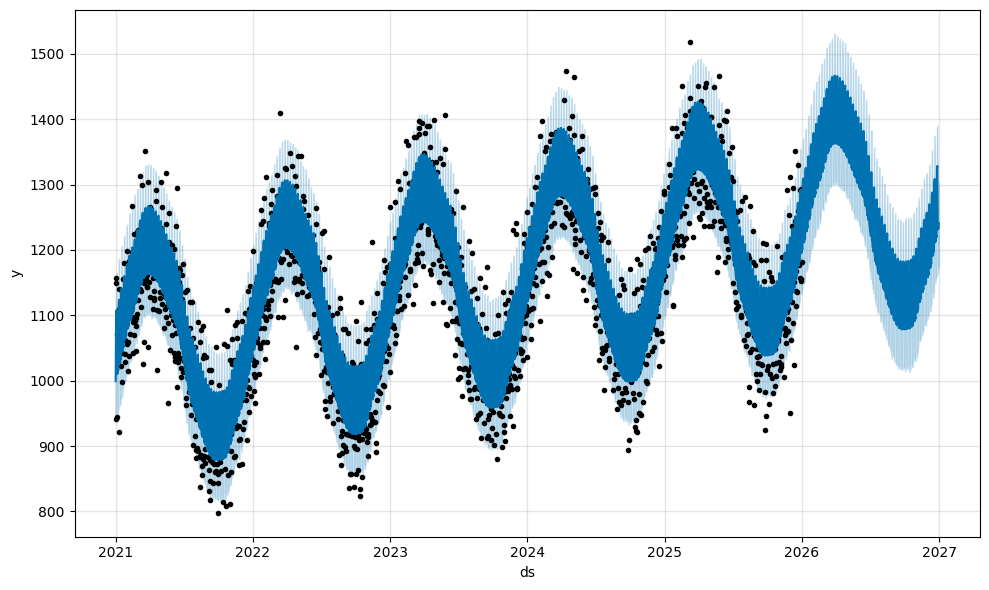

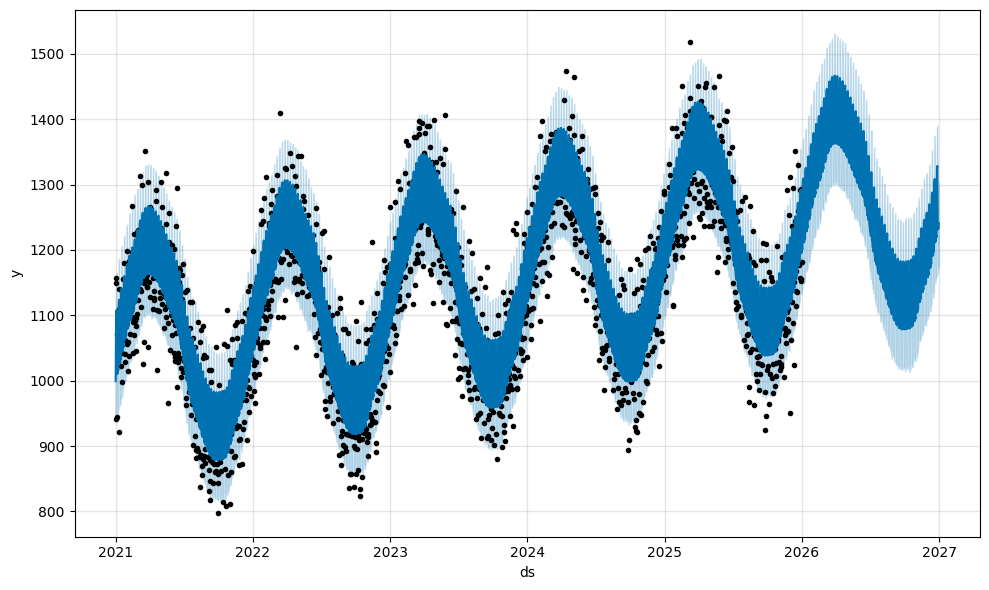

In [19]:
loaded_model.plot(predictions)

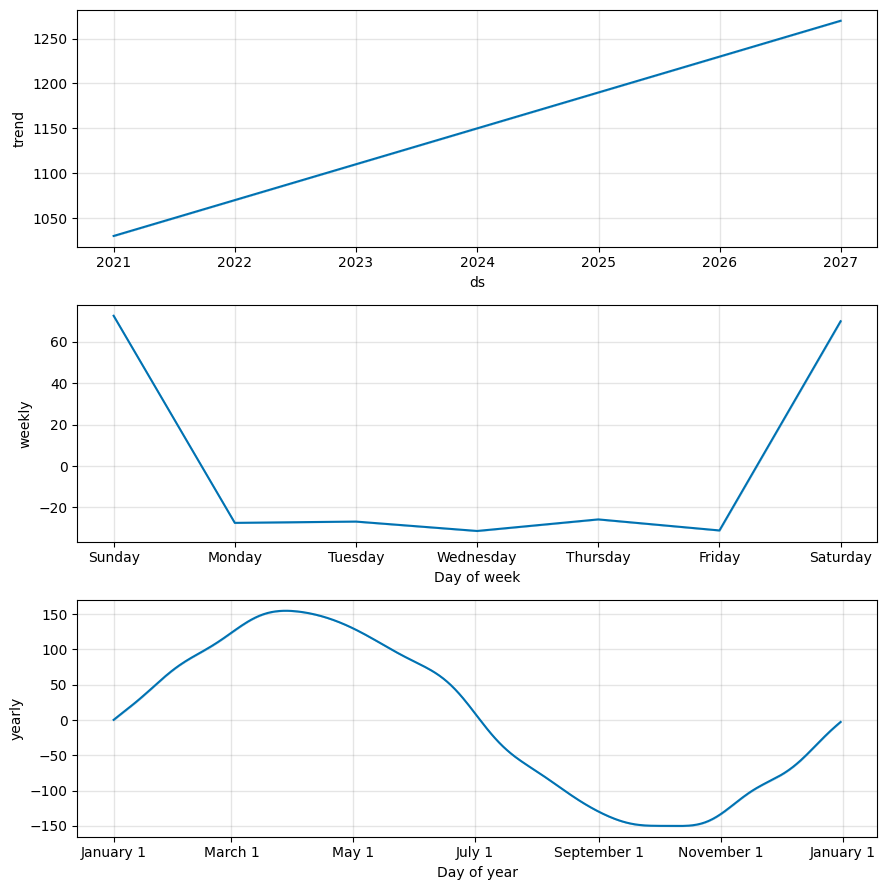

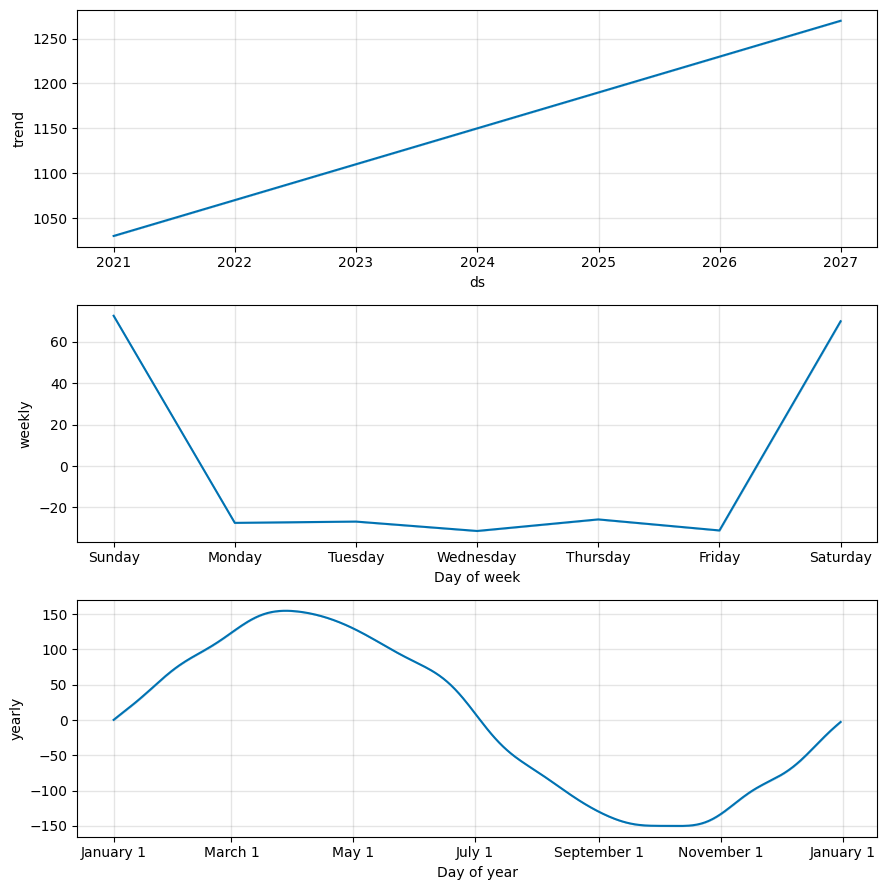

In [20]:
loaded_model.plot_components(predictions)

# Production Deployment Patterns

In [34]:
class ProphetForecaster:
    """Production-ready Prophet forecaster class."""

    def __init__(self, model_uri):
        self.model_uri = model_uri
        self.model = None
        self.last_training_date = None

    def load_model(self):
        """Load the Prophet model."""
        self.model = mlflow.prophet.load_model(self.model_uri)
        if hasattr(self.model, "history"):
            self.last_training_date = self.model.history["ds"].max()

    def predict(self, periods=30, frequency="D", include_history=False):
        """Generate predictions."""
        if self.model is None:
            self.load_model()

        # Generate future dataframe
        future = self.model.make_future_dataframe(
            periods=periods, freq=frequency, include_history=include_history
        )

        # Handle logistic growth
        if self.model.growth == "logistic":
            future["cap"] = future.get("cap", 10000)  # Default capacity

        # Generate forecast
        forecast = self.model.predict(future)

        # Return relevant columns
        columns = ["ds", "yhat", "yhat_lower", "yhat_upper"]
        if not include_history:
            # Return only future predictions
            forecast = forecast.tail(periods)

        return forecast[columns]
        
    def predict_full(self, periods=30, frequency="D", include_history=False):
        """Generate predictions."""
        if self.model is None:
            self.load_model()

        # Generate future dataframe
        future = self.model.make_future_dataframe(
            periods=periods, freq=frequency, include_history=include_history
        )

        # Handle logistic growth
        if self.model.growth == "logistic":
            future["cap"] = future.get("cap", 10000)  # Default capacity

        # Generate forecast
        forecast = self.model.predict(future)

        if not include_history:
            # Return only future predictions
            forecast = forecast.tail(periods)

        return forecast
    def get_components(self, periods=30):
        """Get forecast components."""
        if self.model is None:
            self.load_model()

        future = self.model.make_future_dataframe(periods=periods)
        if self.model.growth == "logistic":
            future["cap"] = future.get("cap", 10000)

        forecast = self.model.predict(future)

        # Extract components
        components = {}
        for component in ["trend", "yearly", "weekly"]:
            if component in forecast.columns:
                components[component] = forecast[["ds", component]].tail(periods)

        return components

    def check_model_freshness(self, current_date=None):
        """Check if model needs retraining."""
        if current_date is None:
            current_date = pd.Timestamp.now()

        if self.last_training_date is None:
            return False, "No training date available"

        days_since_training = (current_date - self.last_training_date).days

        # Define freshness threshold (e.g., 30 days)
        freshness_threshold = 30

        is_fresh = days_since_training < freshness_threshold
        message = f"Model is {days_since_training} days old"

        return is_fresh, message


# Usage
forecaster = ProphetForecaster(model_uri)
predictions = forecaster.predict(periods=90)
components = forecaster.get_components(periods=90)
predictions_full = forecaster.predict_full(periods=90)
is_fresh, message = forecaster.check_model_freshness()

In [33]:
predictions.head()

,ds,yhat,yhat_lower,yhat_upper
0,2026-01-01,1203.887934,1142.373761,1269.984213
1,2026-01-02,1200.972528,1136.054055,1261.097276
2,2026-01-03,1304.281152,1236.023688,1367.804481
3,2026-01-04,1309.280218,1244.179143,1373.979011
4,2026-01-05,1211.702385,1149.260691,1275.555723


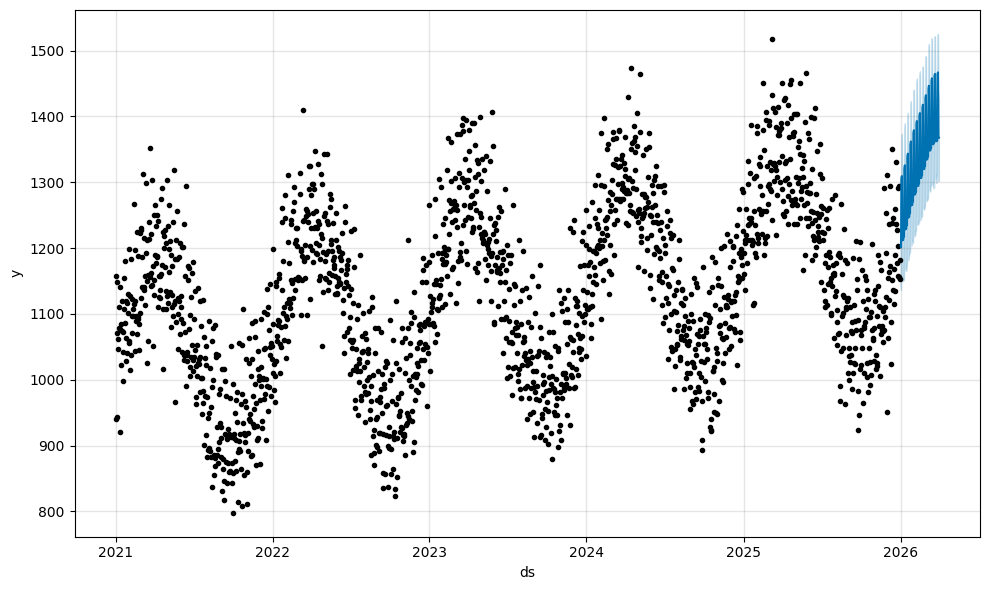

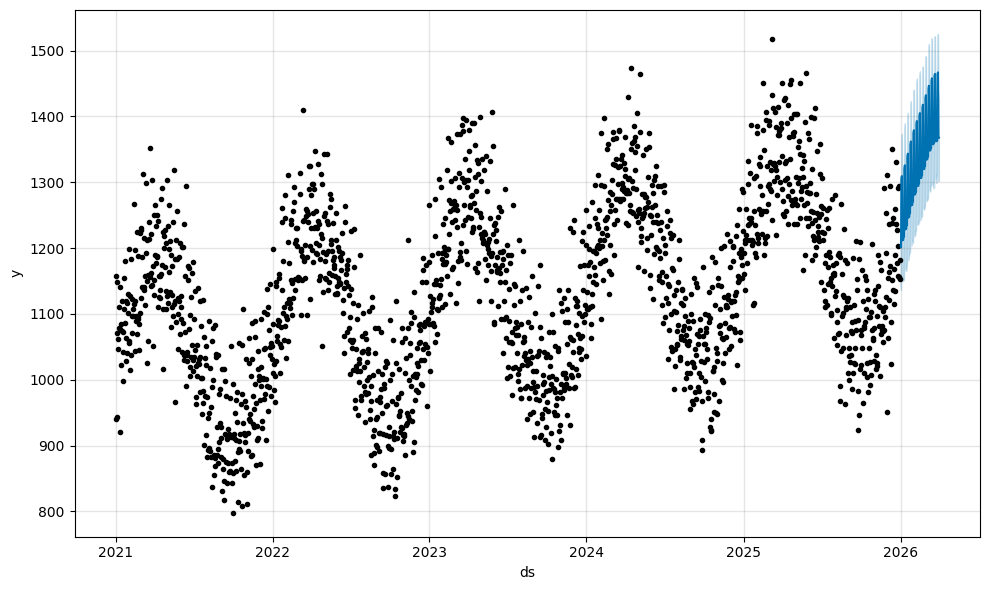

In [24]:
forecaster.model.plot(predictions)

In [31]:
components.keys()

dict_keys(['trend', 'yearly', 'weekly'])

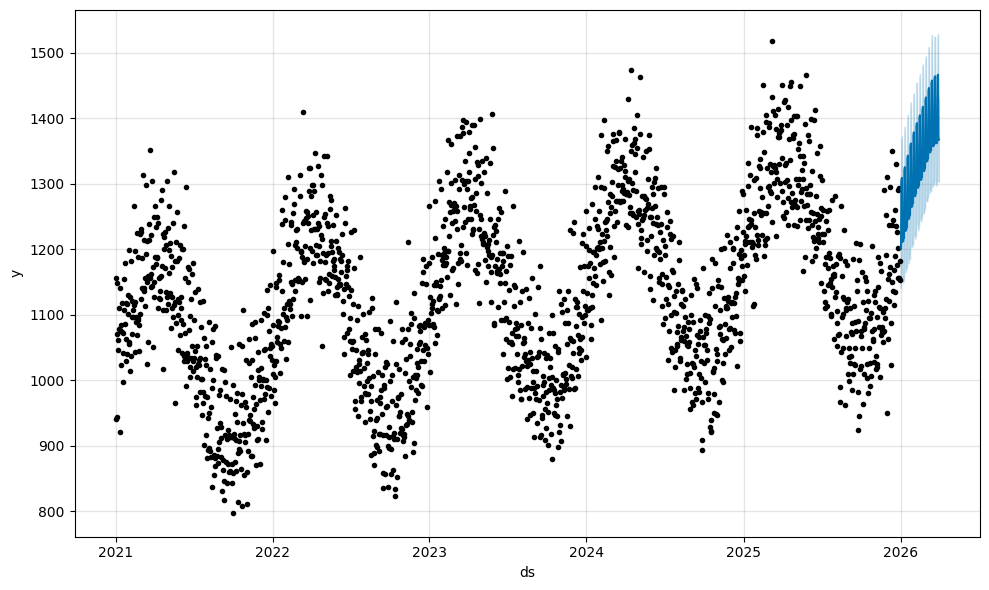

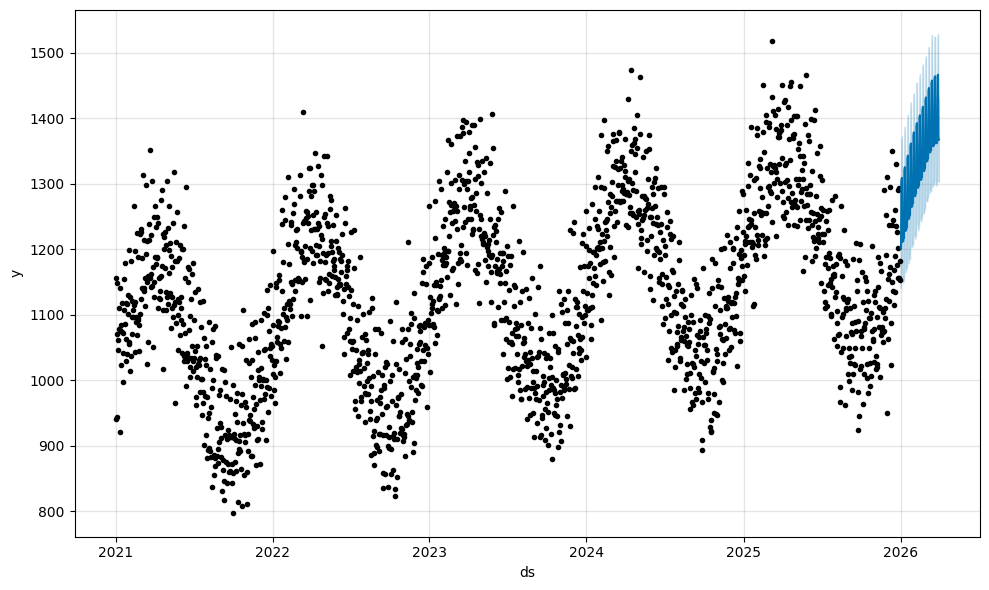

In [35]:
forecaster.model.plot(predictions_full)

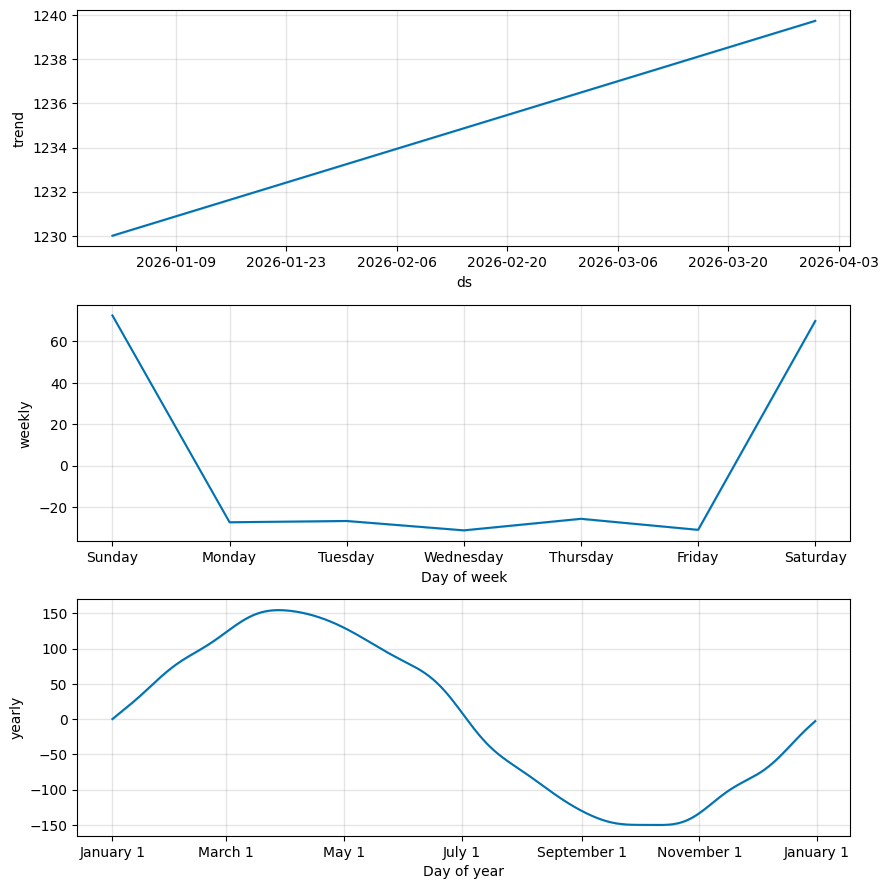

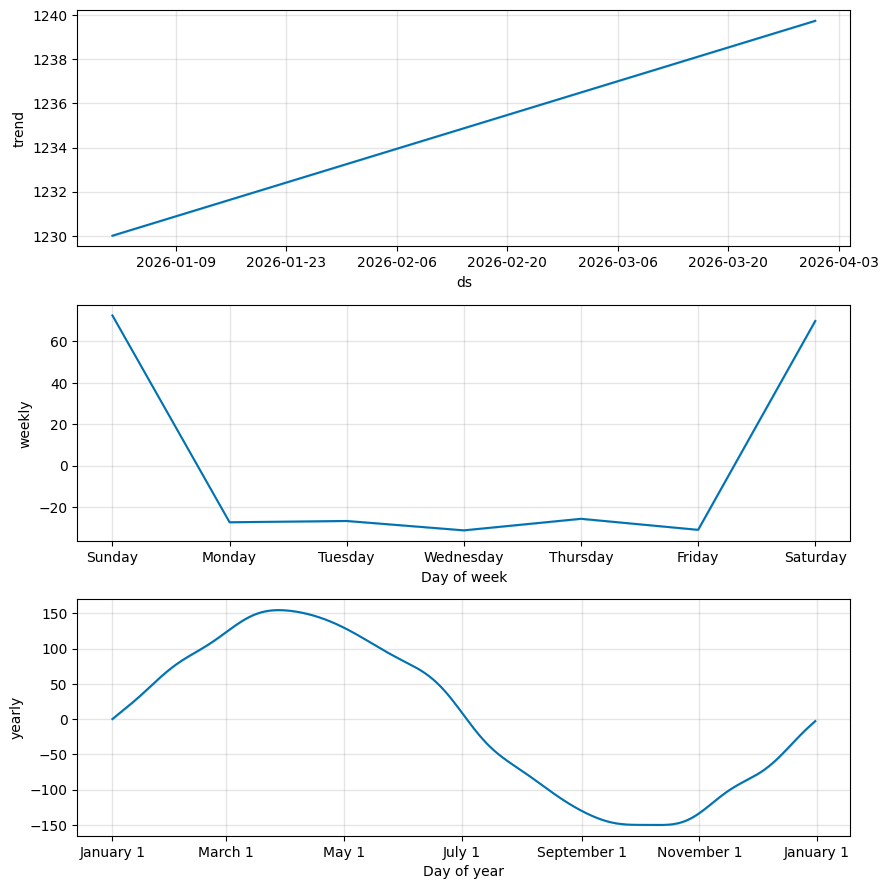

In [36]:
forecaster.model.plot_components(predictions_full)

# Batch Prediction Pipeline

In [39]:
def batch_prophet_predictions(model_uri):
    """Run batch predictions for multiple time series."""

    with mlflow.start_run(run_name="Batch Prophet Predictions"):
        # Load production model

        model = mlflow.prophet.load_model(model_uri)

        # Generate predictions for different horizons
        horizons = [30, 90, 365]  # Days
        predictions = {}

        for horizon in horizons:
            future = model.make_future_dataframe(periods=horizon)
            if model.growth == "logistic":
                future["cap"] = 10000  # Set capacity

            forecast = model.predict(future)

            # Store predictions
            predictions[f"{horizon}_days"] = forecast[
                ["ds", "yhat", "yhat_lower", "yhat_upper"]
            ].tail(horizon)

            # Log prediction summary
            pred_summary = {
                f"{horizon}d_mean_forecast": forecast["yhat"].tail(horizon).mean(),
                f"{horizon}d_forecast_range": forecast["yhat"].tail(horizon).max()
                - forecast["yhat"].tail(horizon).min(),
            }
            mlflow.log_metrics(pred_summary)

        # Save predictions as artifacts
        for horizon, pred_df in predictions.items():
            filename = f"predictions_{horizon}.csv"
            pred_df.to_csv(filename, index=False)
            mlflow.log_artifact(filename)

        # Log batch prediction metadata
        mlflow.log_params(
            {
                "model_uri": model_uri,
                "prediction_date": pd.Timestamp.now().isoformat(),
                "horizons": horizons,
            }
        )

        return predictions

In [40]:
predictions = batch_prophet_predictions(model_uri)

🏃 View run Batch Prophet Predictions at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/a0cf4749ba314bf6a20071f91347e85f
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250
